In [1]:
using Revise
using RxInfer, ReactiveMP, Distributions, LinearAlgebra, Plots, Flux, DelimitedFiles, StableRNGs
using CCMP
using Base
using BenchmarkTools
using StatsFuns

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **


 where T<:Real) where T<:Real) in module ReactiveMP at /Users/mykola/.julia/packages/ReactiveMP/Dm45i/src/distributions/wishart.jl:57 overwritten in module ExponentialFamily at /Users/mykola/.julia/packages/ExponentialFamily/GDUT4/src/distributions/wishart.jl:57.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [9]:
function Base.prod(::ProdAnalytical, left::GammaShapeRate{Float64}, right::ContinuousUnivariateLogPdf)
#     rng, nr_samples, nr_iterations, optimizer = StableRNG(42), 1, 10, Flux.Adam(0.01)
#     cvi = CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 20, Val(true), true)
#     return ReactiveMP.prod(cvi, left, right)
    _, sample_friendly = ReactiveMP.logpdf_sample_friendly(left)
    # @show sample_friendly
    samples = rand(StableRNG(42), sample_friendly, 1000)
    weights = pdf.(Ref(right), samples)
    # weights = weights ./ sum(weights)
    return convert(GammaShapeRate, Distributions.fit(Gamma, samples, weights))
end

In [10]:
# define CVMP forward rule
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))

    projected_m_out = CCMP.proj(method, GammaShapeRate, getdata(m_out)) 
    
    # @show m_ins
    q_y_params = naturalparams(prod(method, getdata(m_ins[1]), projected_m_out, q_ins[1], getnodefn(Val(:out))))
    # @show q_y_params
    # @show naturalparams(projected_m_out)
    return convert(Distribution, q_y_params - naturalparams(projected_m_out))
end

<!-- ┌ Info: HERE!
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:7
┌ Info: ReactiveMP.FactorizedJoint{Tuple{GammaShapeRate{Float64}}}((GammaShapeRate{Float64}(a=13605.986147431206, b=13.435354995502149),))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:8
┌ Info: (Message(Gamma{Float64}(α=1000.0, θ=1.0)),)
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:9
┌ Info: Message(GammaShapeRate{Float64}(a=1.0, b=1.0))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:10
Output exceeds the size limit. Open the full output data in a text editorMethodError: no method matching prod(::ProdCVI{StableRNGs.LehmerRNG, Descent, ForwardDiffGrad, false}, ::Gamma{Float64}, ::GammaShapeRate{Float64}, ::GammaShapeRate{Float64}, ::typeof(identity))
Closest candidates are:
  prod(!Matched::ProdGeneric, ::Any, ::Any, ::Any, ::Any, !Matched::DistProduct, !Matched::DistProduct) at ~/.julia/packages/ReactiveMP/Dm45i/src/constraints/prod/prod_generic.jl:123
  prod(::ProdCVI, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/approximations/cvi.jl:93
  prod(!Matched::ReactiveMP.EqualityChain, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/nodes/equality.jl:78
  ... -->


In [11]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

5 colums dataset
https://www.sidc.be/silso/infosnytot
Contents:

Column 1: Gregorian calendar year (mid-year date)

Column 2: Yearly mean total sunspot number.

Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.

Column 4: Number of observations used to compute the yearly mean total sunspot number.

Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the

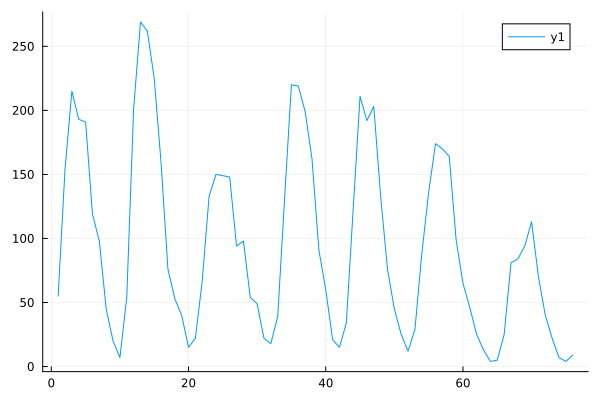

In [12]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
not_rounded = map((s) -> s[2], select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [13]:
hello(x) = StatsFuns.softplus(x)

hello (generic function with 1 method)

In [14]:
@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 2)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(hello(z[t-1]), γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, nr_gradpoints, optimizer)
    hello() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), nr_gradpoints, Val(false), false)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;

In [26]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
CCMP.benchmark_timings[] = 0.0
@time results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1, 1000, 20, Flux.Descent(0.001)),
    # meta = sunspot_meta(StableRNG(42), 1, 1000, 1000, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2, 1), z=Gamma(2, 1), )
)
@show string(CCMP.benchmark_timings[] / 1e9, " sec")
results.free_energy

 17.821868 seconds (162.15 M allocations: 8.094 GiB, 5.49% gc time, 4.27% compilation time: 42% of which was recompilation)
string(CCMP.benchmark_timings[] / 1.0e9, " sec") = "4.82721704 sec"


10-element Vector{Real}:
 9636.540986569444
 6716.464829882676
 6055.483611700707
 5931.704855233789
 5930.635443957434
 5937.953551645536
 5943.216472574056
 5961.184116843749
 5945.487159231981
 5978.844284932082

In [27]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours) 
ribbon = map(x -> var(x), posteriours)
sqrt(mean((not_rounded - means).^2))

22.896342527304746

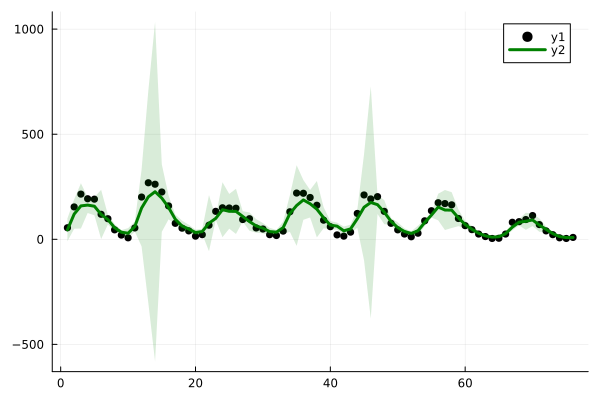

In [28]:
p1 = scatter(observations,color=:black)

plot!(means, ribbon=ribbon, fillalpha=0.15, linewidth=3, color = :green)

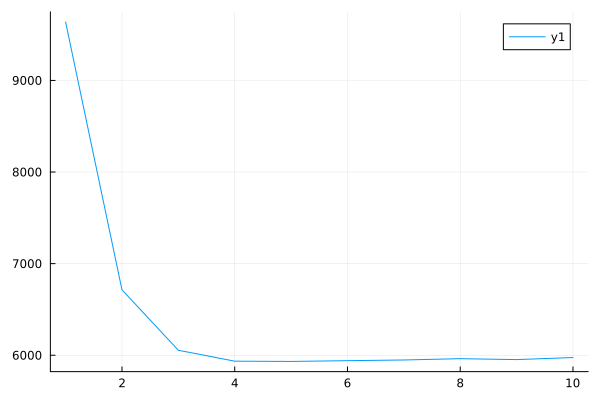

In [54]:
plot(results.free_energy[1:end])

In [58]:
@benchmark results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1, 1000, 20, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2, 1), z=Gamma(2, 1), )
)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 16.737 s (4.18% GC) to evaluate,
 with a memory estimate of 7.90 GiB, over 158326321 allocations.

In [25]:
sqrt(mean((not_rounded - means).^2))

30.527566082719268

In [56]:
open("estimations/cvmp_accurate_sunspot_results.csv", "w") do io
    writedlm(io, [means ribbon])
end

open("estimations/cvmp_accurate_fe_sunspot_results.csv", "w") do io
    writedlm(io, [results.free_energy])
end

In [ ]:
struct A{T} where T
    a::T
end